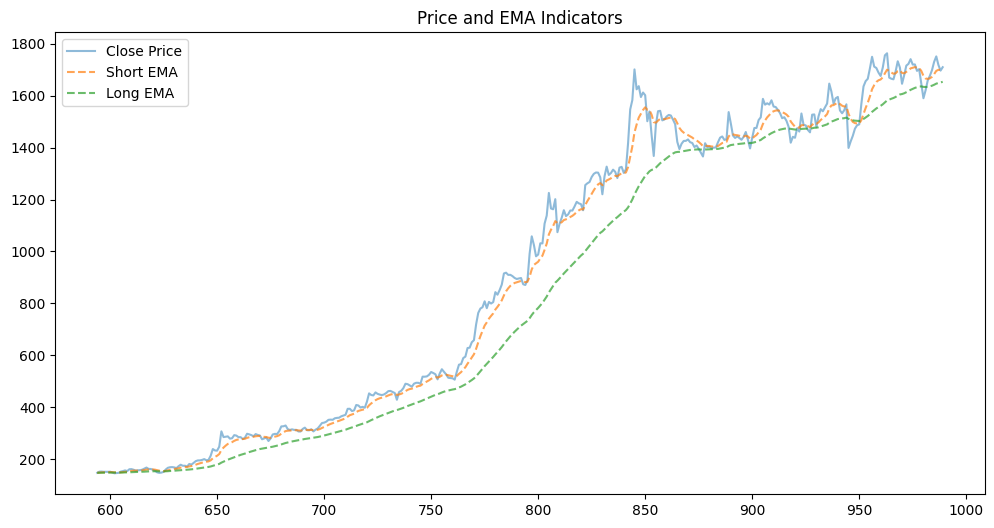

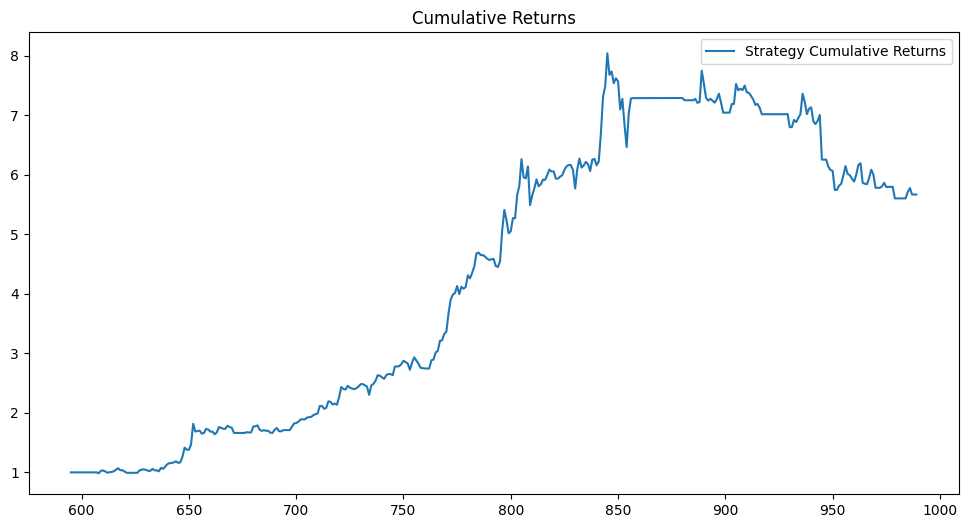

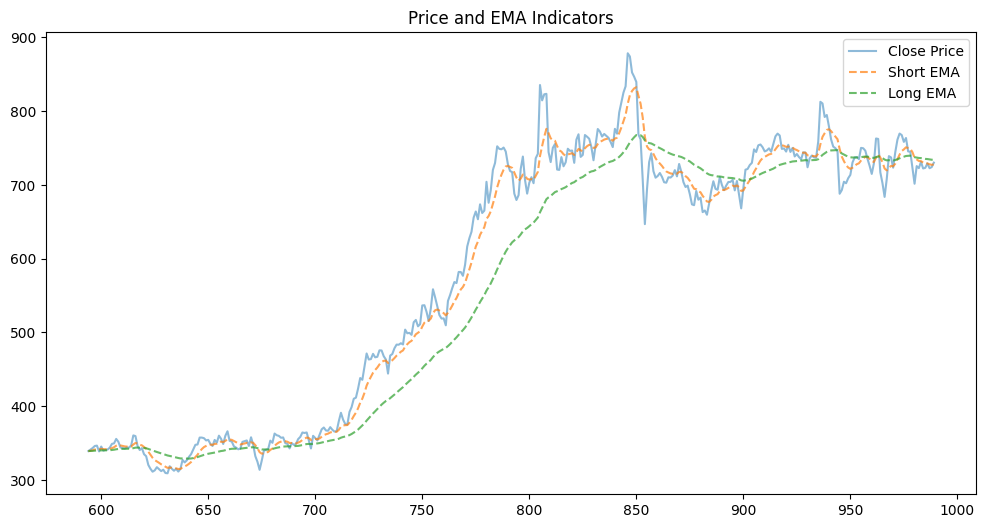

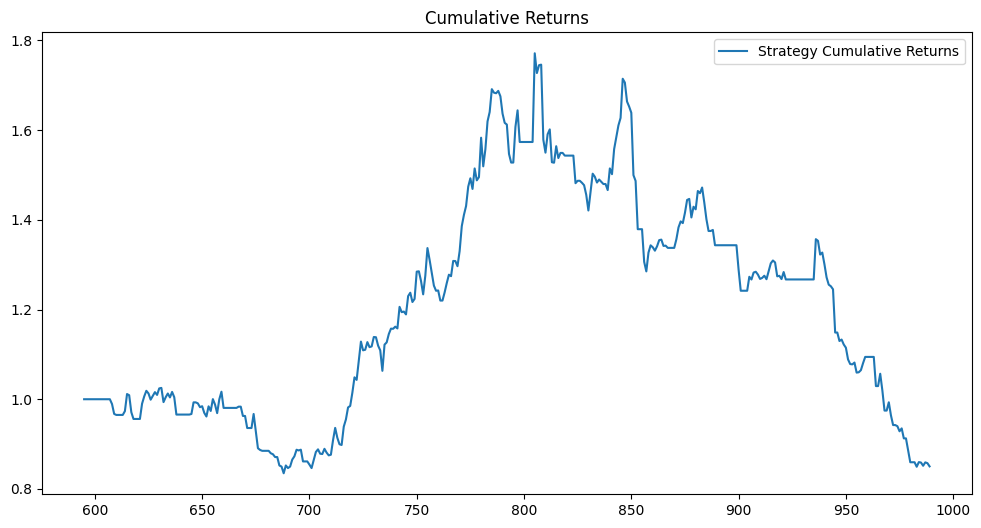

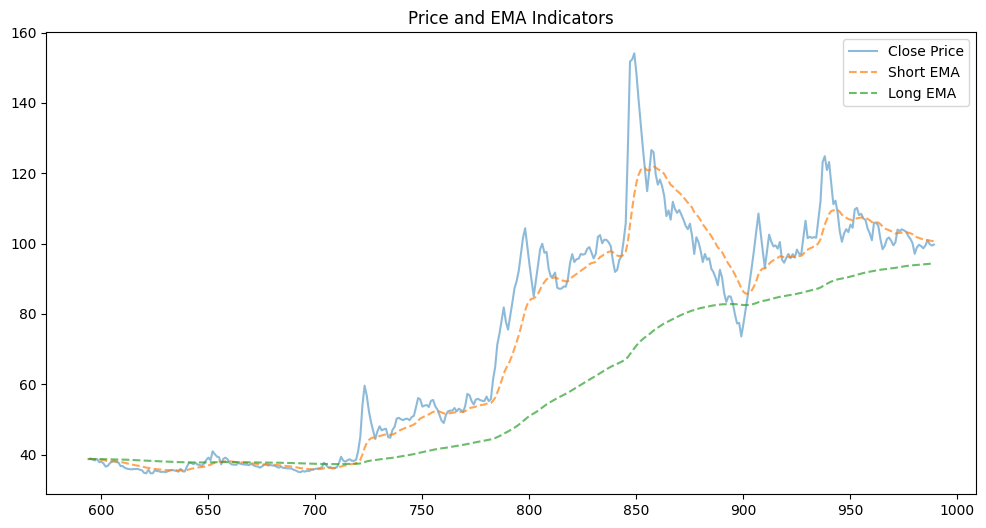

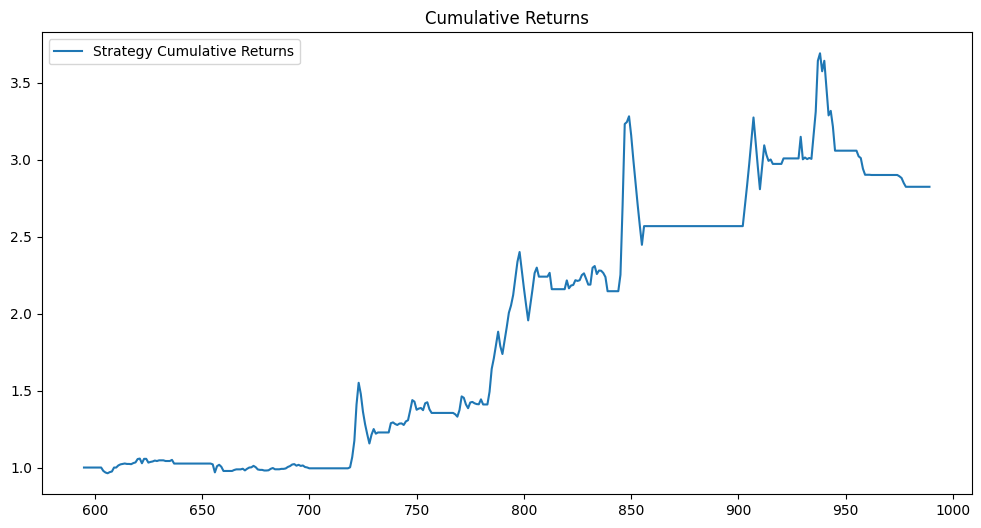

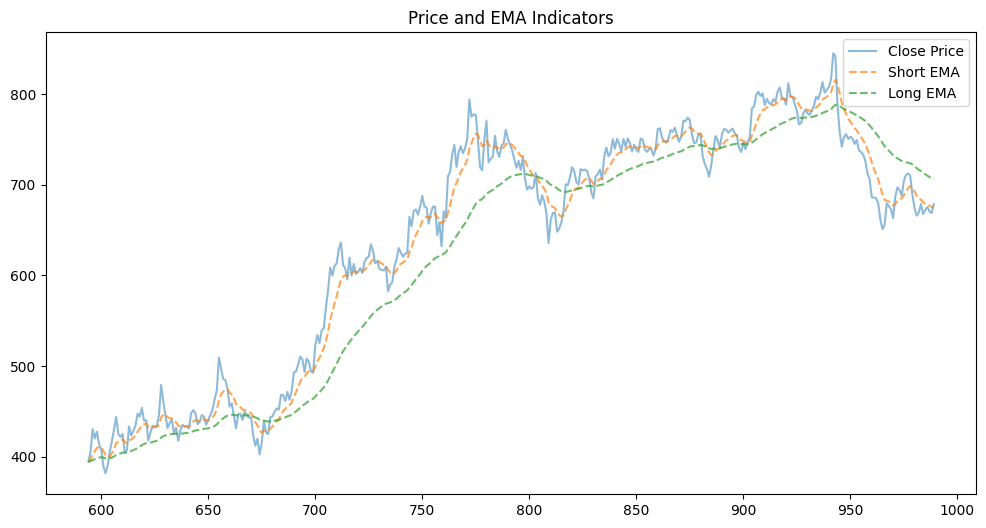

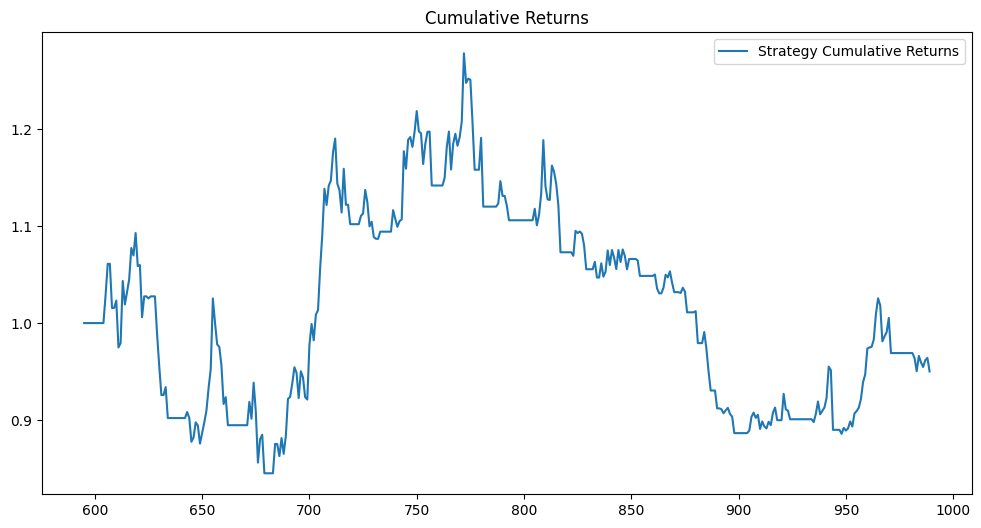

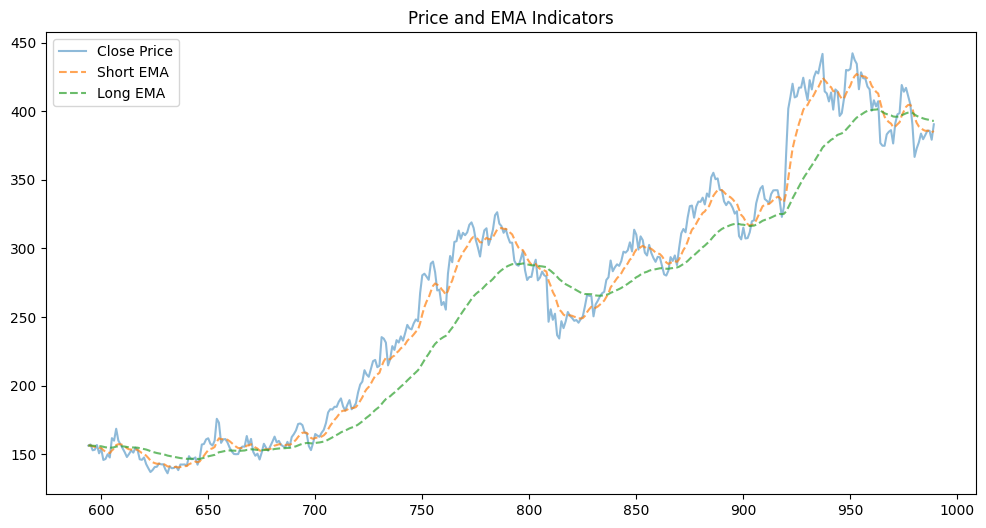

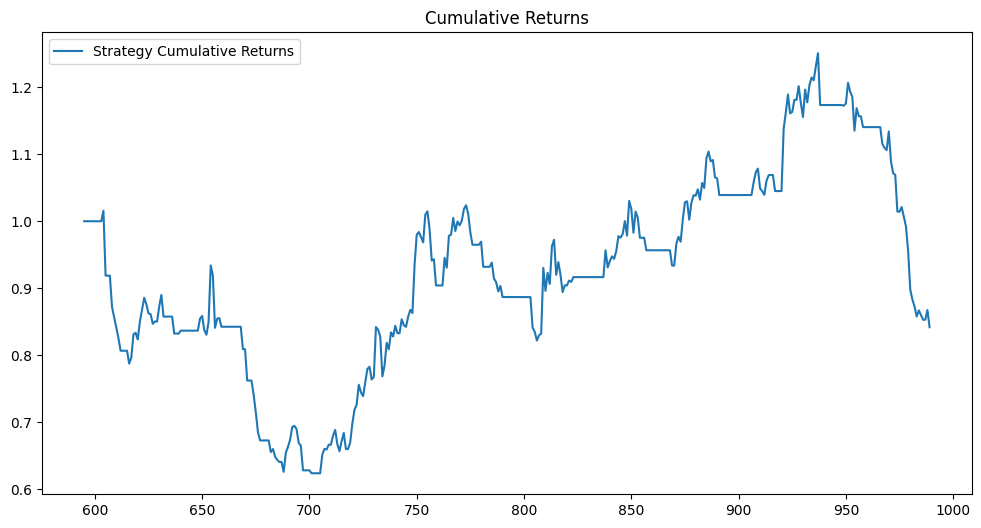

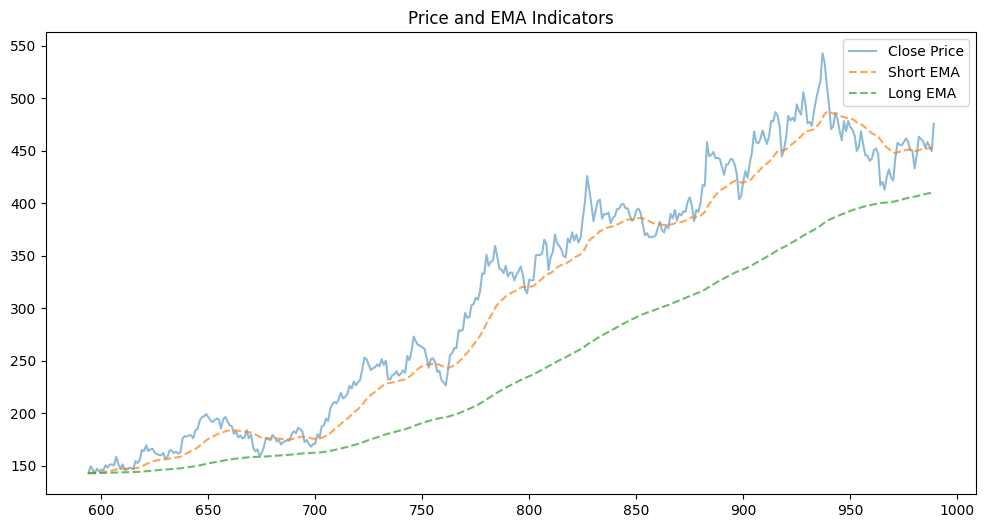

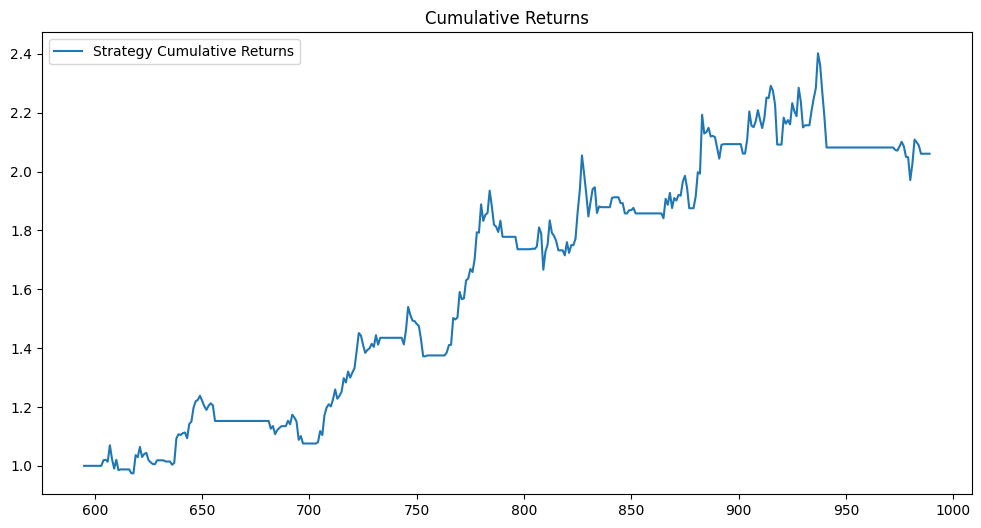

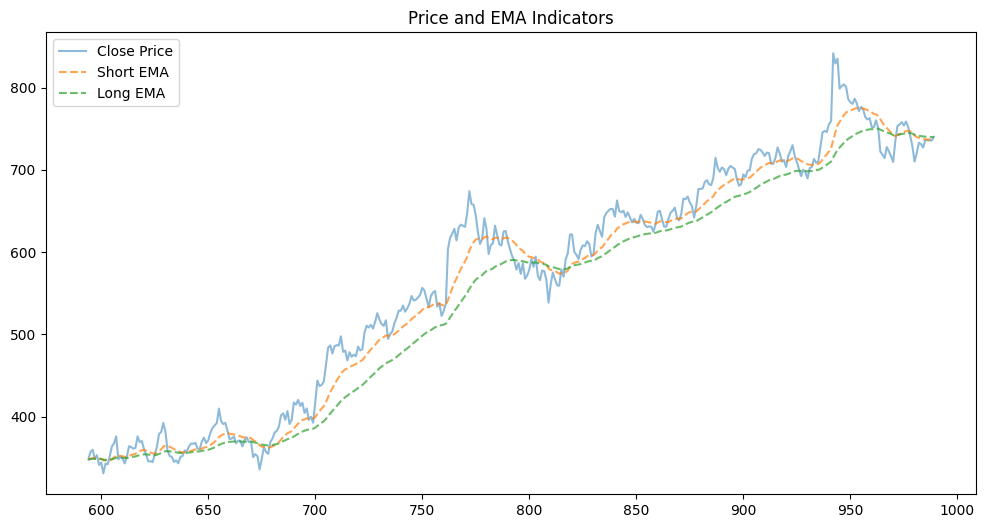

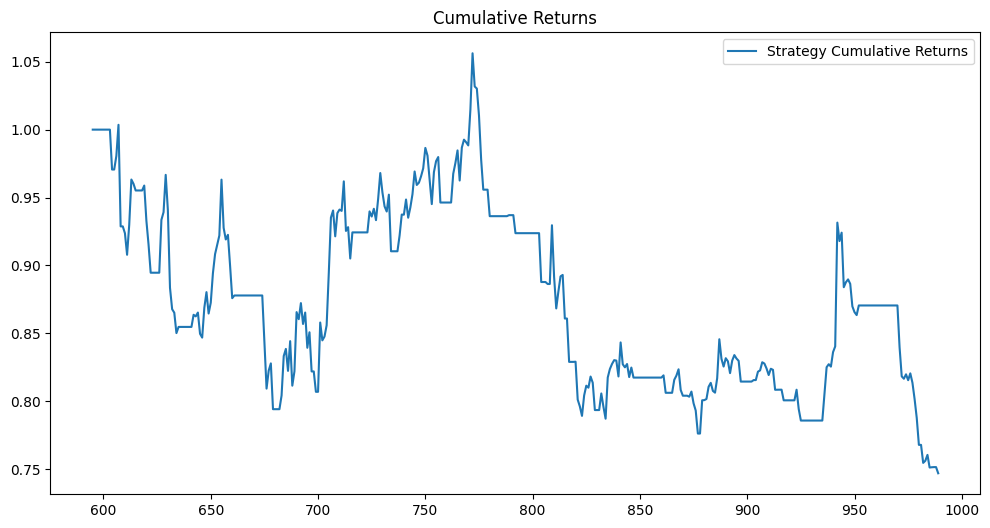

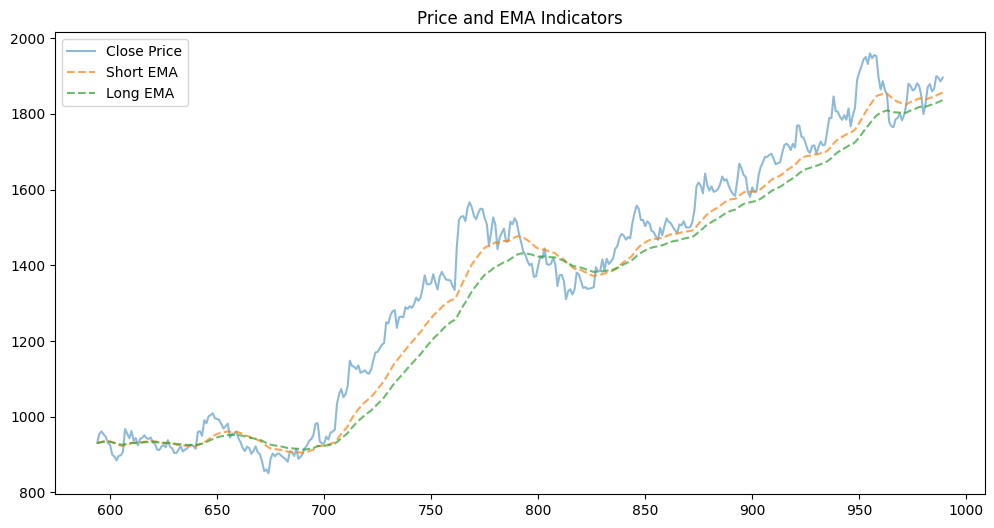

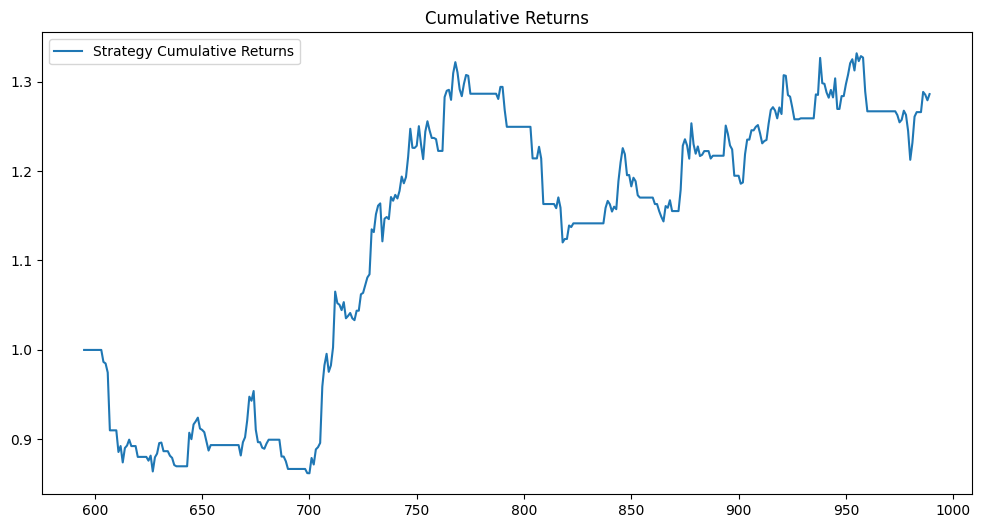

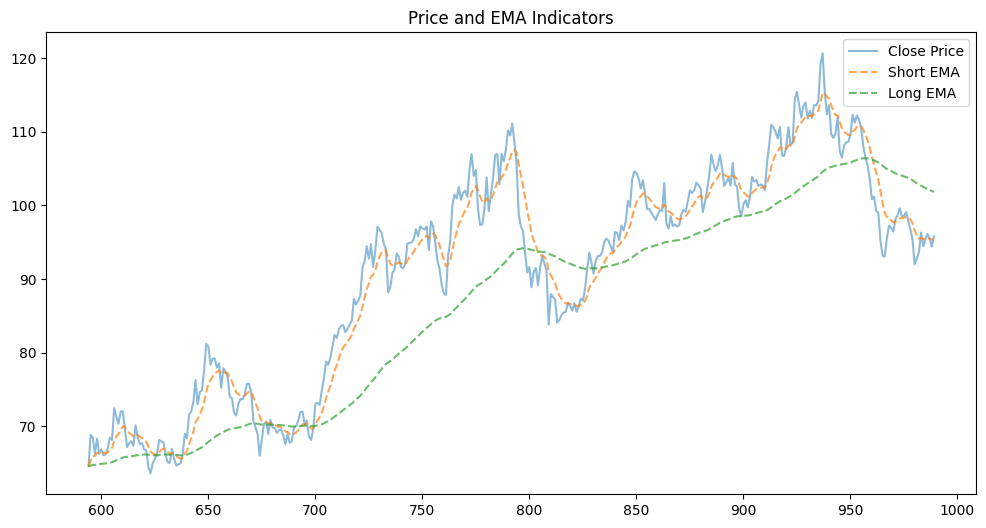

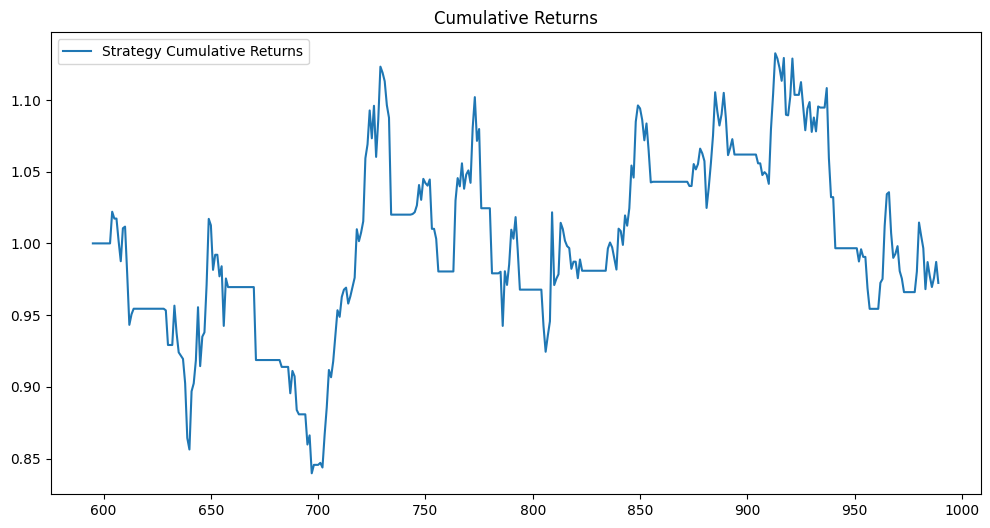

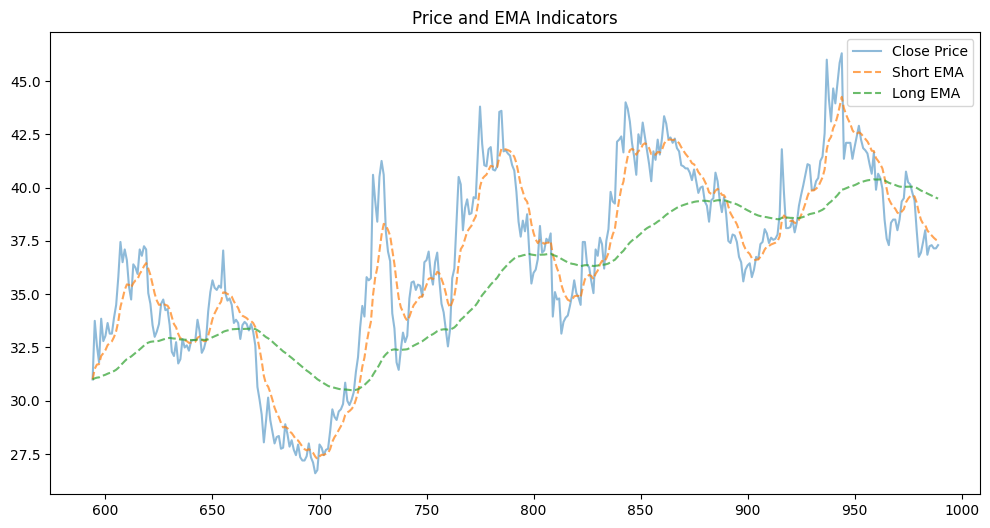

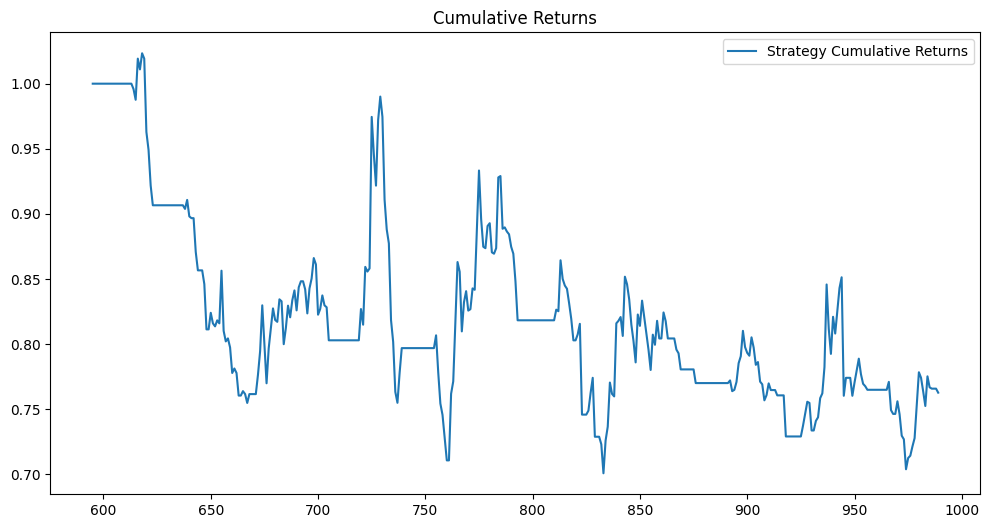

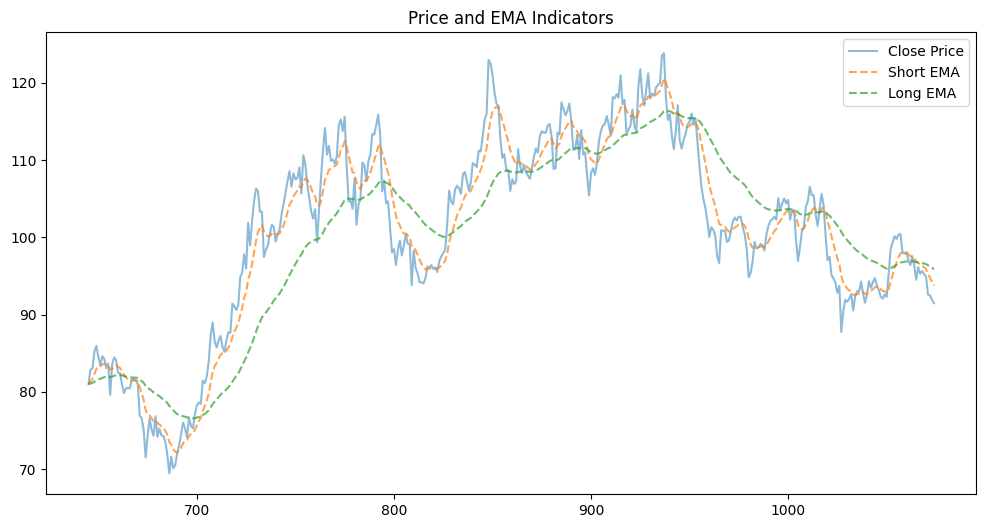

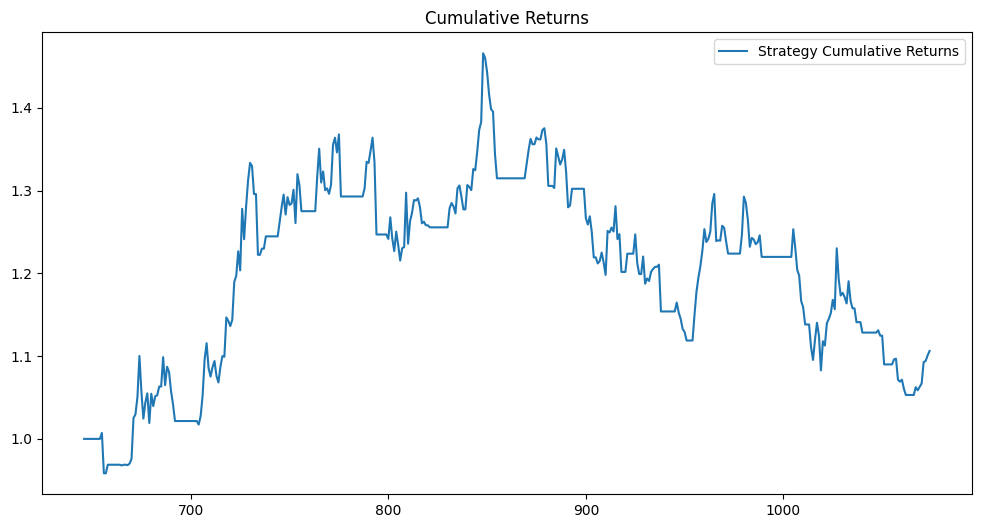

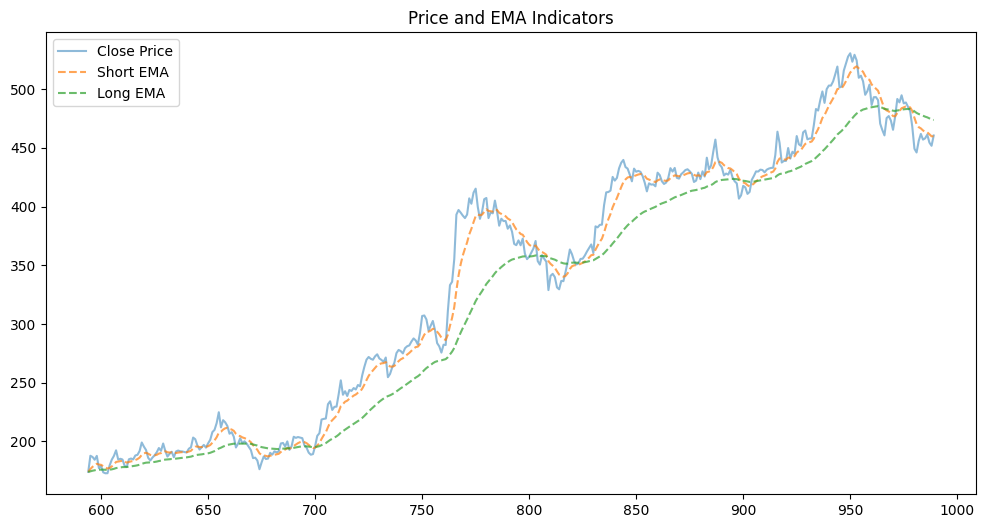

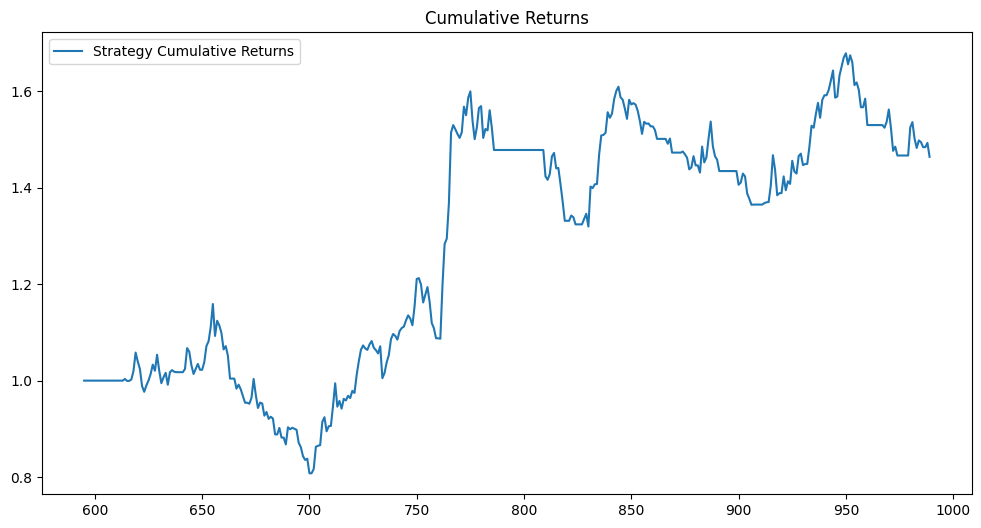

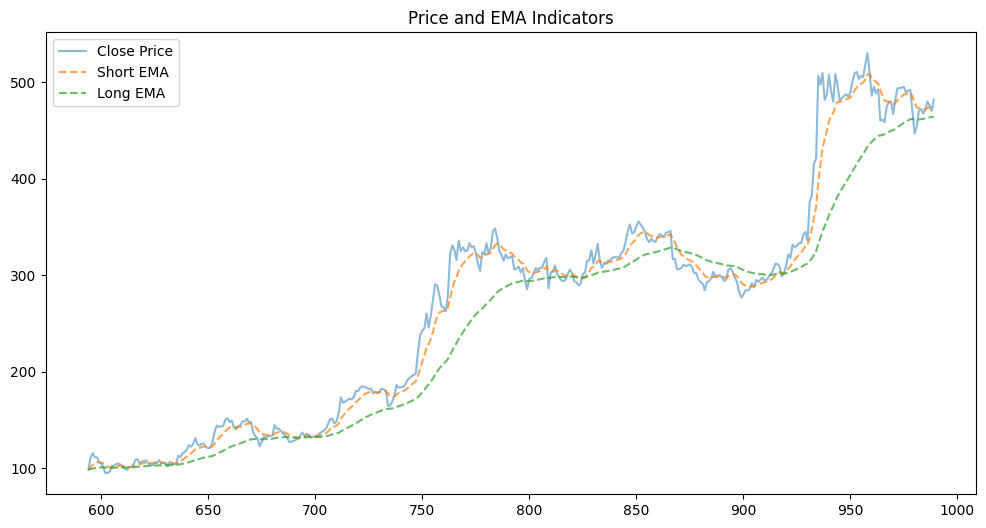

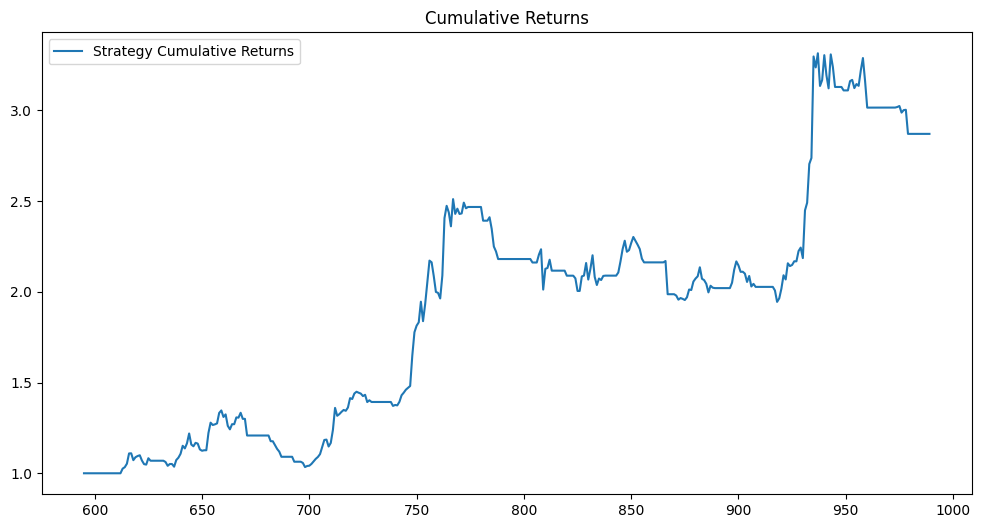

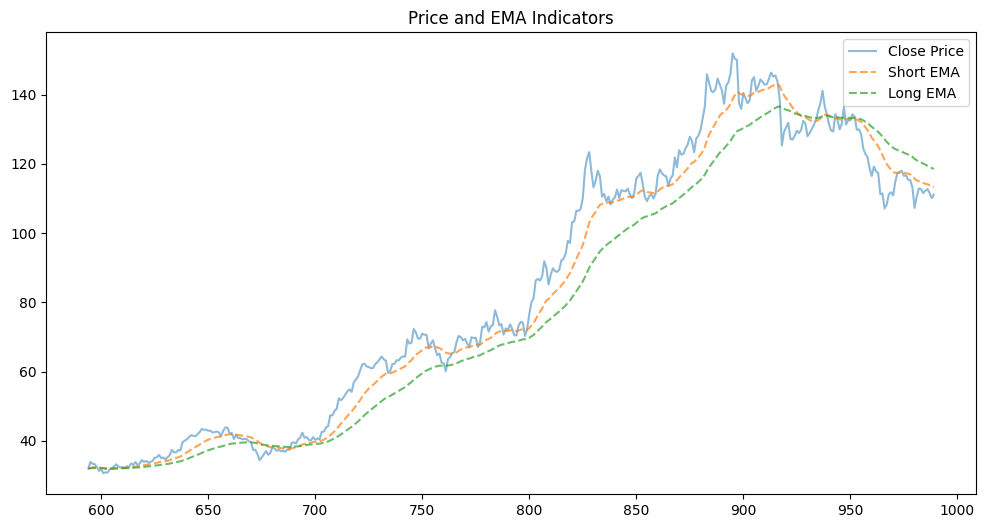

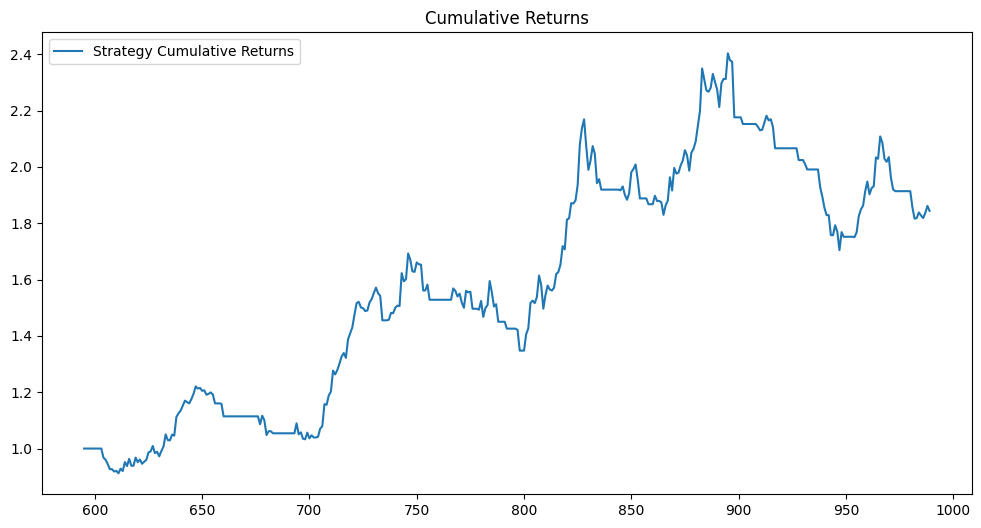

<ipython-input-2-88ce1d247592>:103: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['Change%'] = data['Close'].pct_change() * 100
<ipython-input-2-88ce1d247592>:42: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['Daily_Return'] = data['Close'].pct_change()


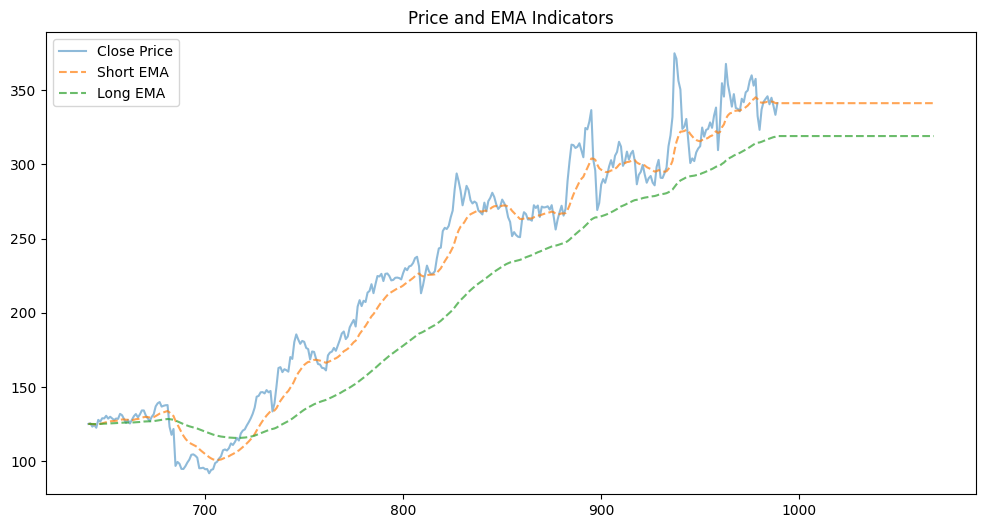

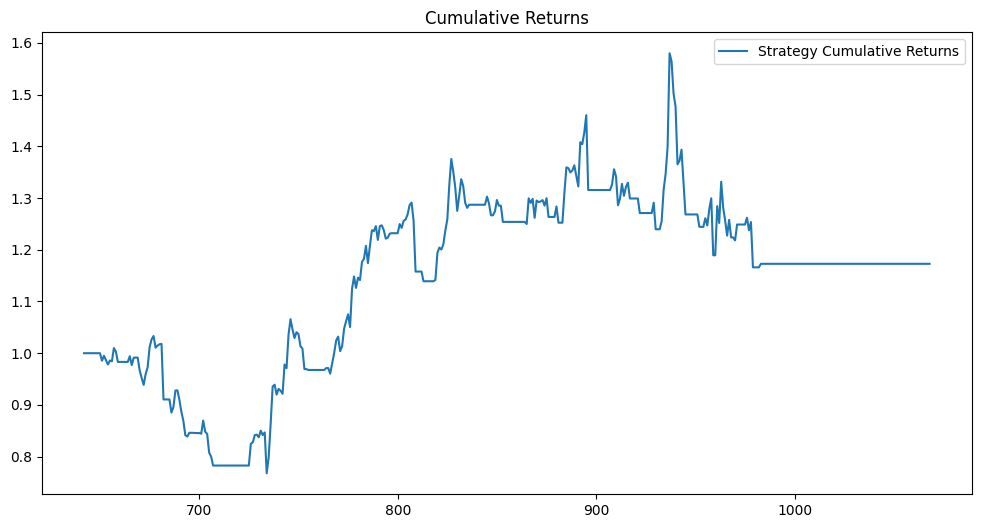

Dataset: /content/Adani Enterprises.csv
Best Parameters: (10, 50, 14)
Performance Metrics:
  Sharpe Ratio: 2.61
  Max Drawdown: -0.30
  Cumulative Return: 5.67

Dataset: /content/Adani Ports & SEZ.csv
Best Parameters: (10, 50, 14)
Performance Metrics:
  Sharpe Ratio: -0.14
  Max Drawdown: -0.52
  Cumulative Return: 0.85

Dataset: /content/Adani Power.csv
Best Parameters: (20, 200, 10)
Performance Metrics:
  Sharpe Ratio: 1.66
  Max Drawdown: -0.25
  Cumulative Return: 2.82

Dataset: /content/Axis Bank.csv
Best Parameters: (10, 50, 10)
Performance Metrics:
  Sharpe Ratio: 0.03
  Max Drawdown: -0.31
  Cumulative Return: 0.95

Dataset: /content/DLF.csv
Best Parameters: (10, 50, 10)
Performance Metrics:
  Sharpe Ratio: -0.12
  Max Drawdown: -0.39
  Cumulative Return: 0.84

Dataset: /content/Hindalco Industries.csv
Best Parameters: (30, 200, 10)
Performance Metrics:
  Sharpe Ratio: 1.59
  Max Drawdown: -0.18
  Cumulative Return: 2.06

Dataset: /content/ICICI Bank.csv
Best Parameters: (20, 5

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def compute_rsi(data, window):
    """Calculate Relative Strength Index (RSI)."""
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_atr(data, window):
    """Calculate Average True Range (ATR)."""
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    tr = high_low.combine(high_close, max).combine(low_close, max)
    atr = tr.rolling(window=window).mean()
    return atr

def generate_signals(data, short_window, long_window, rsi_period, atr_period):
    """Generate trading signals based on technical indicators."""
    # Compute Indicators
    data['Short_EMA'] = data['Close'].ewm(span=short_window, adjust=False).mean()
    data['Long_EMA'] = data['Close'].ewm(span=long_window, adjust=False).mean()
    data['RSI'] = compute_rsi(data['Close'], rsi_period)
    data['ATR'] = compute_atr(data, atr_period)

    # Signal Generation
    data['Signal'] = 0
    data['Signal'] = np.where((data['Short_EMA'] > data['Long_EMA']) & (data['RSI'] > 50), 1, data['Signal'])
    data['Signal'] = np.where((data['Short_EMA'] < data['Long_EMA']) & (data['RSI'] < 50), -1, data['Signal'])

    return data

def backtest_strategy(data):
    """Backtest the generated signals and calculate performance metrics."""
    # Calculate Strategy Returns
    data['Daily_Return'] = data['Close'].pct_change()
    data['Strategy_Return'] = data['Signal'].shift(1) * data['Daily_Return']

    # Performance Metrics
    sharpe_ratio = data['Strategy_Return'].mean() / data['Strategy_Return'].std() * np.sqrt(252)
    cumulative_returns = (1 + data['Strategy_Return']).cumprod()
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()

    performance = {
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Cumulative Return': cumulative_returns.iloc[-1]
    }

    return performance, cumulative_returns

def plot_results(data, cumulative_returns):
    """Plot the results of the strategy."""
    plt.figure(figsize=(12, 6))
    plt.plot(data['Close'], label='Close Price', alpha=0.5)
    plt.plot(data['Short_EMA'], label='Short EMA', linestyle='--', alpha=0.7)
    plt.plot(data['Long_EMA'], label='Long EMA', linestyle='--', alpha=0.7)
    plt.title('Price and EMA Indicators')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_returns, label='Strategy Cumulative Returns')
    plt.title('Cumulative Returns')
    plt.legend()
    plt.show()

def tune_parameters_and_backtest(data, short_windows, long_windows, rsi_periods):
    """Optimize parameters for the strategy."""
    best_performance = None
    best_params = None

    for short_window in short_windows:
        for long_window in long_windows:
            for rsi_period in rsi_periods:
                if short_window >= long_window:
                    continue

                temp_data = data.copy()
                temp_data = generate_signals(temp_data, short_window, long_window, rsi_period, 14)
                performance, _ = backtest_strategy(temp_data)

                if best_performance is None or performance['Sharpe Ratio'] > best_performance['Sharpe Ratio']:
                    best_performance = performance
                    best_params = (short_window, long_window, rsi_period)

    return best_params, best_performance

def train_multiple_datasets(dataset_paths, short_windows, long_windows, rsi_periods):
    """Train and evaluate strategy on multiple datasets."""
    results = []

    for path in dataset_paths:
        data = pd.read_csv(path)

        # Feature Engineering
        data['Change%'] = data['Close'].pct_change() * 100
        data['Change_vs_Avg%'] = data['Change%'] / data['Change%'].rolling(window=30).mean()

        # Train-Test Split
        train_data, test_data = train_test_split(data, test_size=0.4, shuffle=False)

        # Parameter Tuning on Training Data
        best_params, best_performance = tune_parameters_and_backtest(train_data, short_windows, long_windows, rsi_periods)

        # Generate Signals on Test Data
        short_window, long_window, rsi_period = best_params
        test_data = generate_signals(test_data, short_window, long_window, rsi_period, 14)

        # Backtest on Test Data
        performance, cumulative_returns = backtest_strategy(test_data)

        # Collect Results
        results.append({
            'Dataset': path,
            'Best Parameters': best_params,
            'Performance': performance
        })

        # Plot Results
        plot_results(test_data, cumulative_returns)

    return results

# Paths to datasets (replace with actual paths)
dataset_paths = [
    '/content/Adani Enterprises.csv',
    '/content/Adani Ports & SEZ.csv',
    '/content/Adani Power.csv',
    '/content/Axis Bank.csv',
    '/content/DLF.csv',
    '/content/Hindalco Industries.csv',
    '/content/ICICI Bank.csv',
    '/content/Larsen & Toubro.csv',
    '/content/Power Finance Corporation.csv',
    '/content/Punjab National Bank.csv',
    '/content/Rural Electrification Corporation.csv',
    '/content/State Bank of India.csv',
    '/content/Tata Motors.csv',
    '/content/Tata Steel.csv',
    '/content/Vedanta.csv',
]

# Parameter Ranges
short_windows = [10, 20, 30]
long_windows = [50, 100, 200]
rsi_periods = [10, 14, 20]

# Train on multiple datasets
results = train_multiple_datasets(dataset_paths, short_windows, long_windows, rsi_periods)

# Display Results
for result in results:
    print(f"Dataset: {result['Dataset']}")
    print(f"Best Parameters: {result['Best Parameters']}")
    print("Performance Metrics:")
    for key, value in result['Performance'].items():
        print(f"  {key}: {value:.2f}")
    print()
